## Practical 1: word2vec
<p>Oxford CS - Deep NLP 2017<br>
https://www.cs.ox.ac.uk/teaching/courses/2016-2017/dl/</p>
<p>[Yannis Assael, Brendan Shillingford, Chris Dyer]</p>

- Modify so that embeddings generated only from training set
- Add all the other changes
- Please finish and don't drop

This practical is presented as an IPython Notebook, with the code written for recent versions of **Python 3**. The code in this practical will not work with Python 2 unless you modify it. If you are using your own Python installation, ensure you have a setup identical to that described in the installation shell script (which is intended for use with the department lab machines). We will be unable to support installation on personal machines due to time constraints, so please use the lab machines and the setup script if you are unfamiliar with how to install Anaconda.

To execute a notebook cell, press `shift-enter`. The return value of the last command will be displayed, if it is not `None`.

Potentially useful library documentation, references, and resources:

* IPython notebooks: <https://ipython.org/ipython-doc/3/notebook/notebook.html#introduction>
* Numpy numerical array library: <https://docs.scipy.org/doc/>
* Gensim's word2vec: <https://radimrehurek.com/gensim/models/word2vec.html>
* Bokeh interactive plots: <http://bokeh.pydata.org/en/latest/> (we provide plotting code here, but click the thumbnails for more examples to copy-paste)
* scikit-learn ML library (aka `sklearn`): <http://scikit-learn.org/stable/documentation.html>
* nltk NLP toolkit: <http://www.nltk.org/>
* tutorial for processing xml in python using `lxml`: <http://lxml.de/tutorial.html> (we did this for you below, but in case you need it in the future)

In [1]:
import numpy as np
import os
from random import shuffle
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
% matplotlib inline

### Part 0: Download the TED dataset

In [2]:
import urllib.request
import zipfile
import lxml.etree


In [3]:
# Download the dataset if it's not already there: this may take a minute as it is 75MB
if not os.path.isfile('ted_en-20160408.zip'):
    urllib.request.urlretrieve("https://wit3.fbk.eu/get.php?path=XML_releases/xml/ted_en-20160408.zip&filename=ted_en-20160408.zip",
                               filename="ted_en-20160408.zip")

In [4]:
# For now, we're only interested in the subtitle text, so let's extract that from the XML:
with zipfile.ZipFile('ted_en-20160408.zip', 'r') as z:
    doc = lxml.etree.parse(z.open('ted_en-20160408.xml', 'r'))
input_text = doc.xpath('//content/text()')
tags = doc.xpath('//keywords/text()')


### Part 1: Preprocessing

In this part, we attempt to clean up the raw subtitles a bit, so that we get only sentences. The following substring shows examples of what we're trying to get rid of. Since it's hard to define precisely what we want to get rid of, we'll just use some simple heuristics.

Let's start by removing all parenthesized strings using a regex:

In [5]:
input_text_noparens = [re.sub(r'\([^)]*\)', '', text) 
                       for text in input_text]

In [6]:
texts = [re.sub(r"[^a-z0-9]+", " ", text.lower()) 
         for text in input_text_noparens]

In [7]:
from gensim.models import Word2Vec

In [8]:
tokenized = [text.split(" ") for text in texts]

In [9]:
shuffle = np.random.permutation(np.arange(len(tokenized)))

In [10]:
# shuffled_texts  = np.array(tokenized)[shuffle]

In [11]:
shuffled_texts = []
for i in shuffle:
    shuffled_texts.append(tokenized[i])

In [12]:
# inds = [0,-500,-250,None]
# train,val,test = [shuffled_texts[ind:inds[i+1]] 
# for i,ind in enumerate(inds[:-1])]

In [13]:
train = shuffled_texts[:-500]
val = shuffled_texts[-500:-250]
test = shuffled_texts[-250:]

In [14]:
len(train),len(val),len(test)

(1585, 250, 250)

In [15]:
import pandas as pd

In [22]:
import csv #https://stackoverflow.com/questions/18016037/pandas-parsererror-eof-character-when-reading-multiple-csv-files-to-hdf5
glove = pd.read_csv('glove.6B/glove.6B.50d.txt',sep=' ',quoting=csv.QUOTE_NONE,
                   index_col=0,header=None)

In [23]:
def get_embedding(word):
    try:
        return glove.loc[word]
    except KeyError:
        return np.zeros(50,dtype=np.float32)

def get_embeddings(text):
    return [get_embedding(word) for word in text]

In [24]:
bom_train,bom_val,bom_test\
= [
    np.array([np.mean(get_embeddings(text),axis=0) for text in data])
  for data in [train,val,test]
  ]

In [25]:
bom_train.shape

(1585, 50)

Labels

Each document should be labeled with label from the set: {Too, oEo, ooD, TEo, ToD, oED, TED, ooo}. You are called to generate labels from the <keywords> tag by checking the existence of one of the following tags: {Technology, Entertainment, Design}.

- None of the keywords → ooo
- “Technology” → Too
- “Entertainment” → oEo
- “Design” → ooD
- “Technology” and “Entertainment” → TEo
- “Technology” and “Design” → ToD
- “Entertainment” and “Design” → oED
- “Technology” and “Entertainment” and “Design” → TED

In [26]:
import itertools

def make_label(comb):
    return ''.join([let if num else 'o' for (let,num) in zip('TED',comb)])

all_labels = [make_label(comb) for comb in itertools.product(*[[0,1]]*3)]

label_dict = dict(zip(all_labels ,range(8)))


In [27]:
from sklearn.preprocessing import OneHotEncoder

tags = [tags_i.lower() for tags_i in tags]
labels = [make_label([tags_i.find(tag) >-1 for tag in ['technology','entertainment','design']]) 
          for tags_i in tags]

num_labels = np.array(list(map(label_dict.get,labels)))

enc = OneHotEncoder()
onehot_labels = enc.fit_transform(np.reshape(num_labels,(-1,1))).toarray()

shuffled_labels = onehot_labels[shuffle,:]

# y_train,y_val,y_test = [shuffled_labels[ind:inds[i+1],:] 
#                         for i,ind in enumerate(inds[:-1])]

y_train = shuffled_labels[:-500]
y_val = shuffled_labels[-500:-250]
y_test = shuffled_labels[-250:]

We can see that most of the documents seem to belong to class 0. Looking for these tags might not be the best way to go about this task. The reason is that documents might have similar but not identical keywords. A better strategy might be to use word vectors for technology, entertainment and design and to find tags which are close.

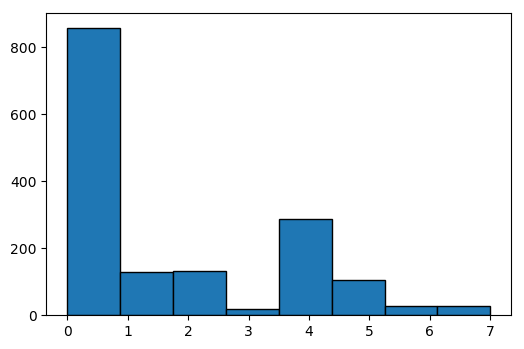

In [28]:
plt.hist(np.argmax(y_train,axis=1),bins=8,ec='k');

In [29]:
import tensorflow as tf
import math

In [ ]:
    with tf.variable_scope('embed'):
    
        embeddings = tf.get_variable('embeddings',
                                    (vocab_size, embed_size),
                                    dtype=tf.float32,
                                    trainable=False)
        rnn_inputs = tf.nn.embedding_lookup(embeddings, X)
    
    with tf.variable_scope('lstm'):
        cell = tf.contrib.rnn.LSTMCell(state_size)
        rnn_outputs, final_state = tf.nn.dynamic_rnn(
                                                     cell=cell,
                                                     inputs=rnn_inputs,
                                                     dtype=tf.float32,
                                                     sequence_length = seqlens)
        
        rnn_outputs = tf.concat(rnn_outputs, 2)
        rnn_outputs = tf.nn.dropout(rnn_outputs, rate_drop_dense)
        range_size = tf.cond(is_test,tf.constant(test_size),tf.constant(batch_size))
        idx = tf.range(2*range_size)*tf.shape(rnn_outputs)[1]\
                + (seqlens - 1)
        last_rnn_outputs = tf.gather(tf.reshape(rnn_outputs,
                                               [-1, state_size]), idx)
        split = tf.split(last_rnn_outputs,2)
        merged = tf.concat(split,axis=1)
    
    with tf.variable_scope('bn1'):
        merged = batch_normalize(merged,is_tr)
    
    with tf.variable_scope('fc1'):
        colms = X.get_shape()[-1].value
        W1 = tf.get_variable('W1',shape=[2*state_size,num_dense])
        b1 = tf.get_variable('b1',shape=[num_dense])

        merged = tf.nn.xw_plus_b(merged,W1,b1)
        merged = tf.nn.dropout(merged,rate_drop_dense)
    
    with tf.variable_scope('bn2'):
        merged = batch_normalize(merged,is_tr)
        
    with tf.variable_scope('softmax'):
        W_out = tf.get_variable('W_out', [num_dense, 2])
        b_out = tf.get_variable('b_out', [2],
            initializer=tf.constant_initializer(0.0))
        logits = tf.nn.xw_plus_b(merged,W_out,b_out)
        
        preds = tf.nn.softmax(logits)
        correct = tf.equal(tf.cast(tf.argmax(preds,1),tf.int32),y)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

        loss = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits,labels=y)
        )
    
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    with tf.control_dependencies(extra_update_ops):
         train_step = tf.train.AdamOptimizer(lr).minimize(loss,
                                                          global_step=global_step)

In [30]:
class TextClassifier():

    def __init__(self,  
                embed_dim,
                hid_dims,
                num_classes,
                nonlin=tf.tanh,
                optimizer=tf.train.AdamOptimizer(5e-4)):
        self.embed_dim = embed_dim
        self.hid_dims = hid_dims
        self.num_classes = num_classes
        self.nonlin = nonlin
        self.optimizer = optimizer
        
    def build_graph(self):
        if 'sess' in globals() and sess:
            sess.close()
        tf.reset_default_graph()
        is_train = tf.placeholder(tf.bool)
        x = tf.placeholder(tf.float32, [None,self.embed_dim])
        y = tf.placeholder(tf.int32,[None,self.num_classes])
        
        dims = [self.embed_dim]+self.hid_dims+[self.num_classes]
        
        h = x
        correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(preds, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        loss = tf.reduce_mean(
          tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=preds))

        train_step = self.optimizer.minimize(loss)
        
        self.x = x
        self.y = y
        self.loss = loss
        self.preds = preds
        self.train_step = train_step
        self.is_train = is_train
        self.accuracy = accuracy
    
    def test(self,data):
        x_test,y_test = data
        with tf.Session() as sess:
            saver = tf.train.Saver()
            saver.restore(sess,'./')
            feed = {self.is_train: False,
                    self.x: x_test,
                    self.y: y_test}
            acc = sess.run([self.accuracy], feed_dict=feed)
        return acc
    
    def get_preds(self,data):
        x_test,y_test = data
        with tf.Session() as sess:
            saver = tf.train.Saver()
            saver.restore(sess,'./')
            feed = {self.is_train: False,
                    self.x: x_test,
                    self.y: y_test}
            preds = sess.run([self.preds], feed_dict=feed)
        return np.argmax(preds[0],axis=1)
        
    def train(self,
                    data,
                    verbose=False,
                    batch_size = 50,
                    num_epochs = 100, 
                    skip_step=10):

        (x_train,y_train),(x_test,y_test) = [data['train'],data['test']]

        with tf.Session() as sess:
            
            sess.run(tf.global_variables_initializer())

            self.tr_accs, self.te_accs = [], []
            self.tr_losses, self.te_losses = [], []

            train_size = x_train.shape[0]

            for epoch in range(num_epochs):
                shuffle = np.random.permutation(np.arange(train_size))
                x_train = x_train[shuffle,:]
                y_train = y_train[shuffle,:]

                accuracy = 0
                losses = []

                for i in range(math.ceil(train_size/batch_size)):
                    ix = slice(i*50,(i+1)*50)
                    feed = {self.is_train: True,
                        self.x: x_train[ix,:],
                        self.y: y_train[ix,:]}

                    acc,_,loss = sess.run([self.accuracy,
                                          self.train_step,
                                          self.loss], 
                                          feed_dict=feed)

                    actual_batch_size = x_train[ix,:].shape[0]
                    losses.append(loss*actual_batch_size)
                    accuracy += acc*actual_batch_size

                feed = {self.is_train: False,
                        self.x: x_test,
                        self.y: y_test}

                val_acc,val_loss = sess.run([self.accuracy,self.loss], feed_dict=feed)

                total_tr_acc = accuracy/x_train.shape[0]
                total_tr_loss = np.sum(losses)/x_train.shape[0]
                if(verbose):
                    print("Epoch {2}, Overall training loss = {0:.3g} and accuracy of {1:.3g}"\
                      .format(total_tr_loss,total_tr_acc,epoch+1))
                    print("Epoch {2}, Overall validation loss = {0:.3g} and accuracy of {1:.3g}"\
                      .format(val_loss,val_acc,epoch+1))

                for val,lst in zip((total_tr_loss,val_loss,total_tr_acc,val_acc),
                                   (self.tr_losses,self.te_losses,self.tr_accs,self.te_accs)):
                    lst.append(val)
            
            saver = tf.train.Saver()
            saver.save(sess,'./')

    def plot(self):
            for i,j in zip(('Train Loss','Val Loss','Train Acc','Val Acc'),
                        [ self.tr_losses, self.te_losses, self.tr_accs, self.te_accs]):
                print(i,j[-1])
            plt.figure(figsize=(16,8))
            plt.subplot(1,2,1)
            plt.plot(self.tr_losses,label='train')
            plt.plot(self.te_losses,label='valid')
            plt.title('Loss per epoch')
            plt.legend()
            plt.subplot(1,2,2)
            plt.plot(self.tr_accs,label='train')
            plt.plot(self.te_accs,label='valid')
            plt.title('Accuracy per epoch')
            plt.legend()

    def train_and_plot(self,
                    data,
                    verbose=False,
                    batch_size = 50,
                    num_epochs = 100, 
                    skip_step=10):
        self.train(data)
        self.plot()


In [31]:
clf = TextClassifier(50,[250],8)

In [32]:
clf.build_graph()

Train Loss 0.979030853942
Val Loss 1.00613
Train Acc 0.639747641816
Val Acc 0.628


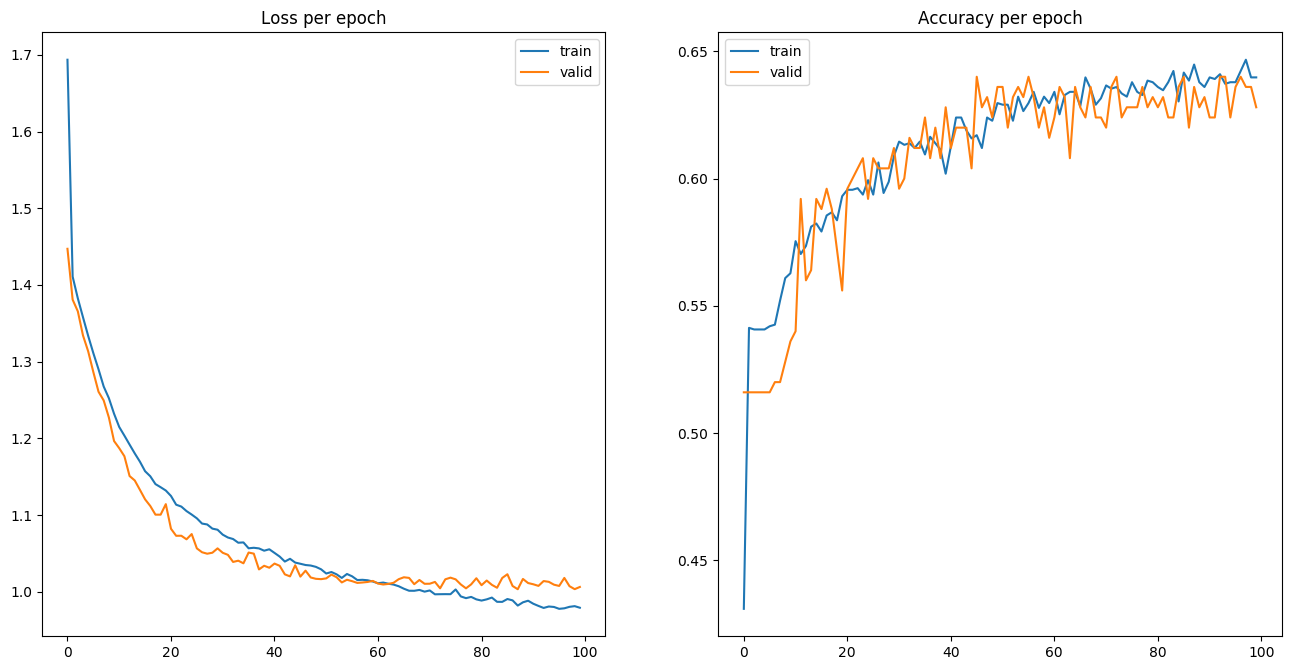

In [33]:
clf.train_and_plot({'train':(bom_train,y_train),'test':(bom_val,y_val)},num_epochs=5000)

In [34]:
from sklearn.metrics import confusion_matrix
confusion_matrix(np.argmax(y_val,axis=1),
                 clf.get_preds((bom_val,y_val)))

INFO:tensorflow:Restoring parameters from ./


INFO:tensorflow:Restoring parameters from ./


array([[111,   5,   1,   0,  12,   0,   0,   0],
       [  9,   7,   0,   0,   1,   2,   0,   0],
       [  7,   0,  10,   0,   1,   0,   0,   0],
       [  0,   1,   0,   0,   0,   0,   0,   0],
       [ 24,   1,   1,   0,  26,   1,   0,   1],
       [  7,   3,   0,   0,   8,   3,   1,   0],
       [  3,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   1,   0,   3,   0,   0,   0]])

Train Loss 0.947305279011
Val Loss 0.989614
Train Acc 0.651104112153
Val Acc 0.636


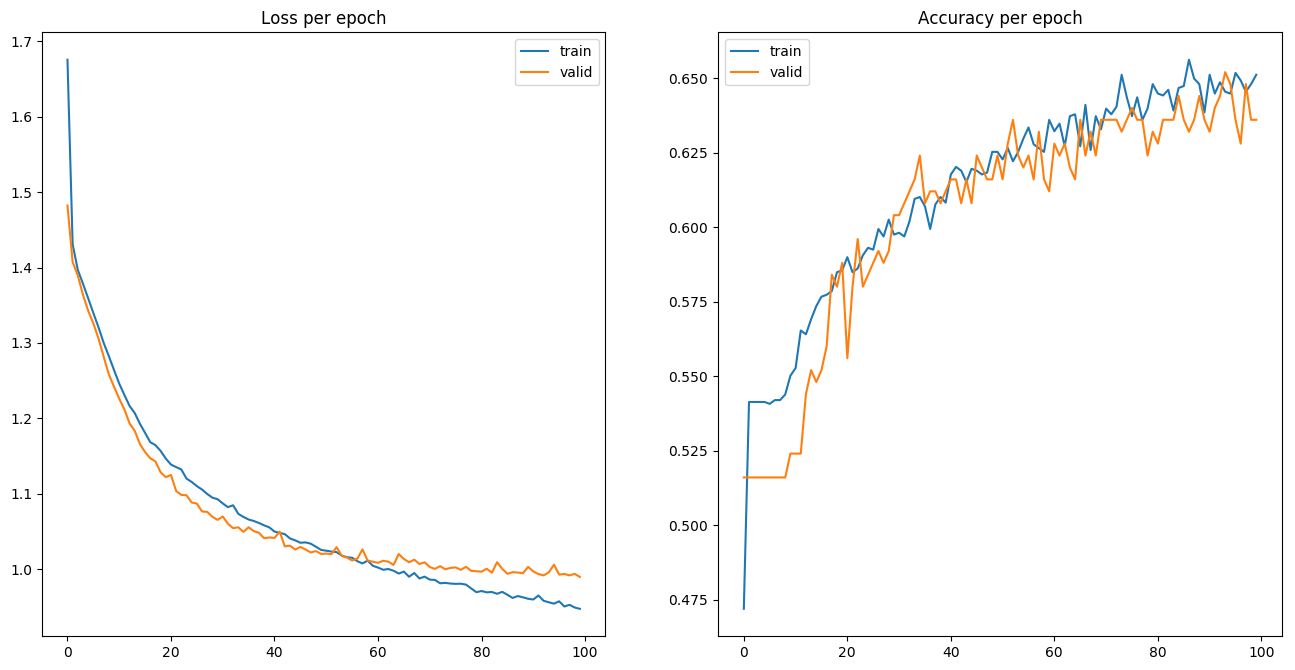

In [35]:
clf2 = TextClassifier(embed_dim=50,hid_dims=[250],num_classes=8,nonlin=tf.nn.relu)
clf2.build_graph()
clf2.train_and_plot({'train':(bom_train,y_train),'test':(bom_val,y_val)},num_epochs=5000)

Train Loss 1.08123293115
Val Loss 1.05512
Train Acc 0.601892744141
Val Acc 0.608


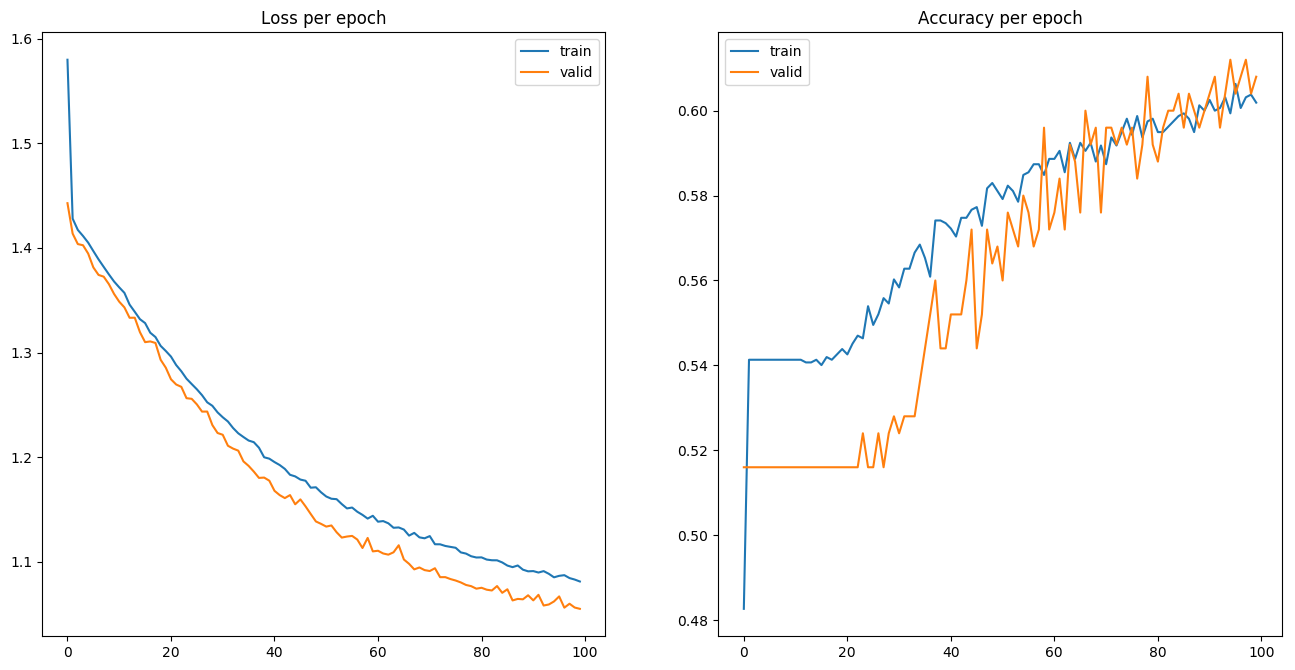

In [36]:
clf3 = TextClassifier(embed_dim=50,hid_dims=[250],num_classes=8,nonlin=tf.sigmoid)
clf3.build_graph()
clf3.train_and_plot({'train':(bom_train,y_train),'test':(bom_val,y_val)},num_epochs=5000)

Train Loss 1.02811589264
Val Loss 1.02226
Train Acc 0.622712934901
Val Acc 0.632


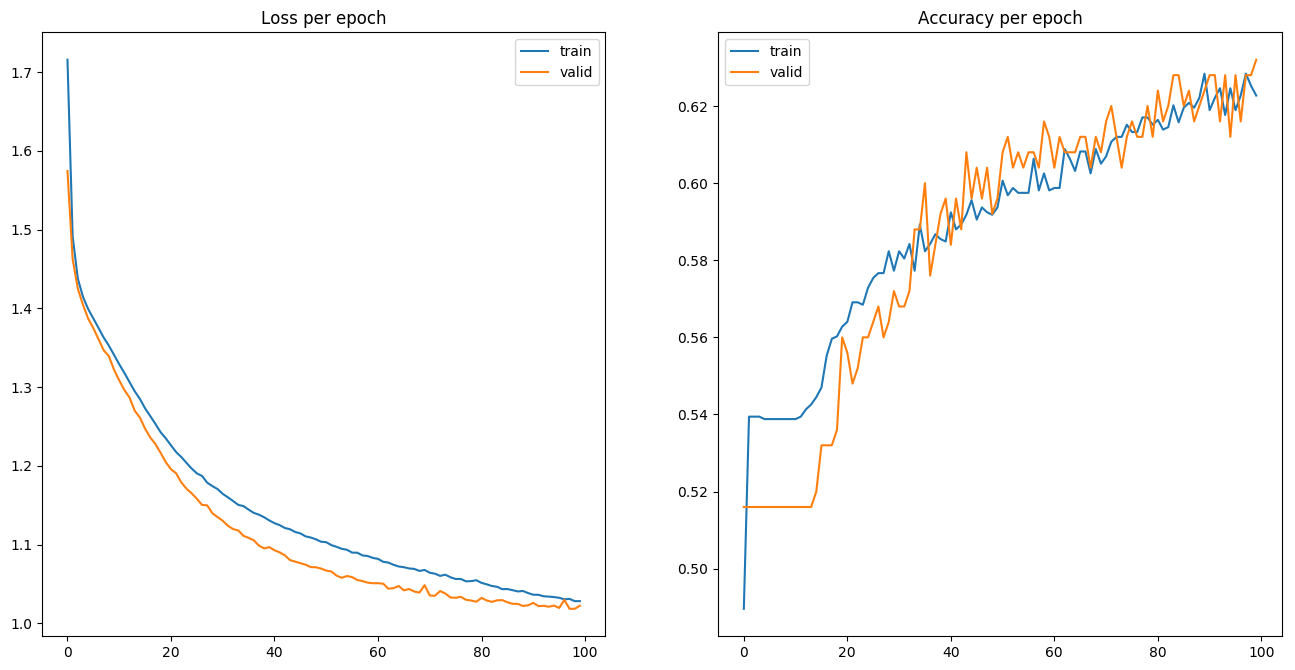

In [37]:
clf4 = TextClassifier(embed_dim=50,hid_dims=[50],num_classes=8,nonlin=tf.tanh)
clf4.build_graph()
clf4.train_and_plot({'train':(bom_train,y_train),'test':(bom_val,y_val)},num_epochs=5000)

Train Loss 0.995422712636
Val Loss 1.01382
Train Acc 0.632176659649
Val Acc 0.632


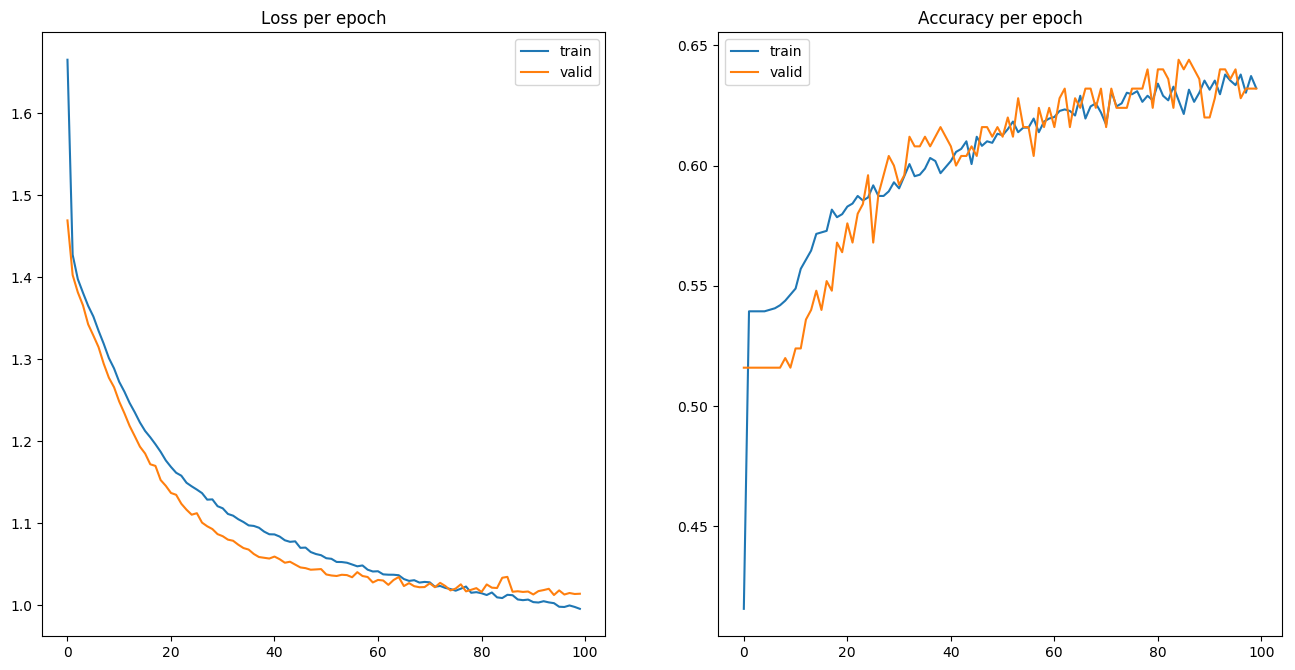

In [38]:
clf5 = TextClassifier(embed_dim=50,hid_dims=[100],num_classes=8,nonlin=tf.tanh)
clf5.build_graph()
clf5.train_and_plot({'train':(bom_train,y_train),'test':(bom_val,y_val)},num_epochs=5000)

Train Loss 0.969423781058
Val Loss 1.00821
Train Acc 0.638485809042
Val Acc 0.632


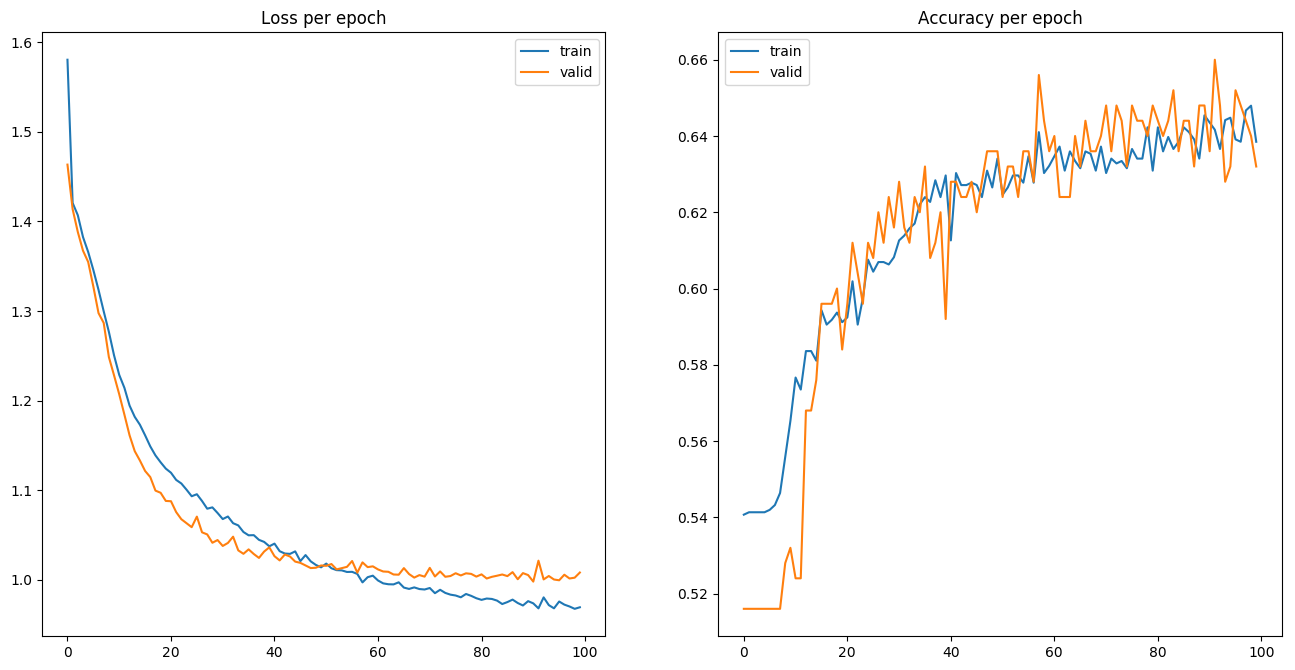

In [39]:
clf6 = TextClassifier(embed_dim=50,hid_dims=[50,50],num_classes=8,nonlin=tf.tanh)
clf6.build_graph()
clf6.train_and_plot({'train':(bom_train,y_train),'test':(bom_val,y_val)},num_epochs=5000)

Train Loss 1.25454158099
Val Loss 1.24295
Train Acc 0.553943216801
Val Acc 0.528


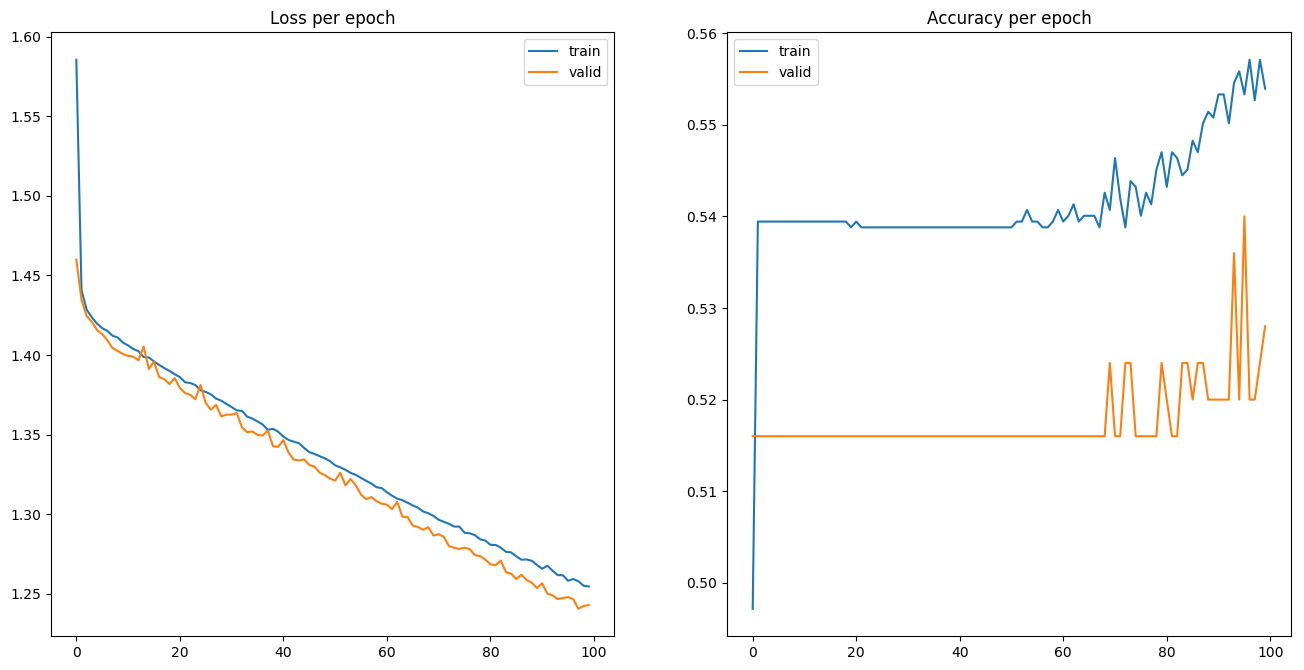

In [40]:
clf7 = TextClassifier(embed_dim=50,hid_dims=[250],
                      num_classes=8,nonlin=tf.tanh,
                     optimizer=tf.train.GradientDescentOptimizer(1e-2))
clf7.build_graph()
clf7.train_and_plot({'train':(bom_train,y_train),'test':(bom_val,y_val)},num_epochs=5000)

Train Loss 0.883037235083
Val Loss 1.18837
Train Acc 0.6763407007
Val Acc 0.604


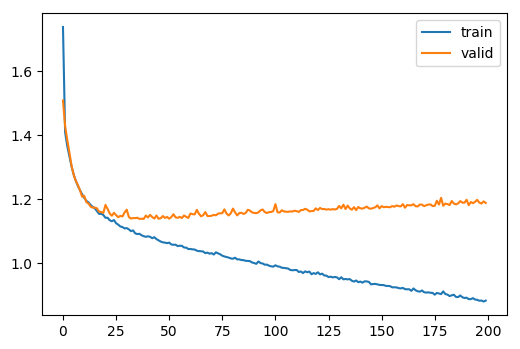

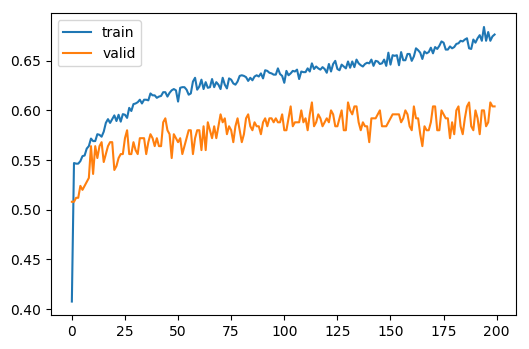

In [141]:
train_and_plot(dict(embed_dim=50,hidden=250,num_classes=8,nonlin=tf.nn.relu),
               dict(num_epochs=200))

Train Loss 1.06142181703
Val Loss 1.16138
Train Acc 0.619558363495
Val Acc 0.564


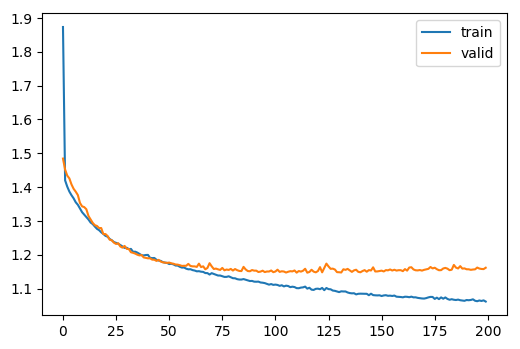

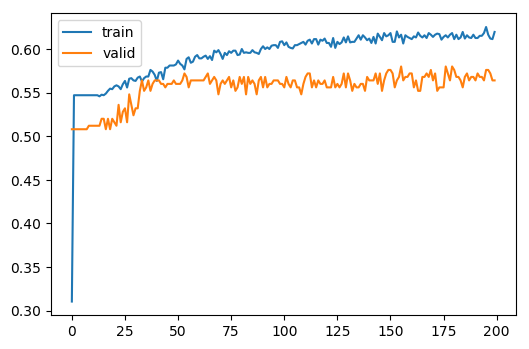

In [142]:
train_and_plot(dict(embed_dim=50,hidden=250,num_classes=8,nonlin=tf.sigmoid),
               dict(num_epochs=200))

Train Loss 1.01349880455
Val Loss 1.21049
Train Acc 0.623343850912
Val Acc 0.544


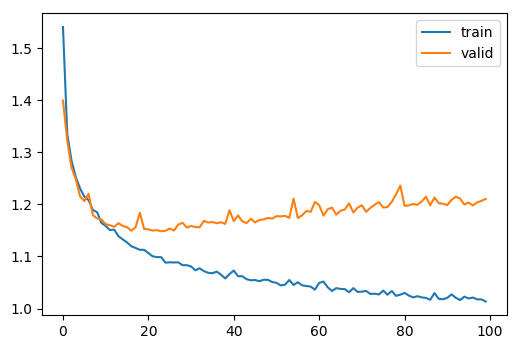

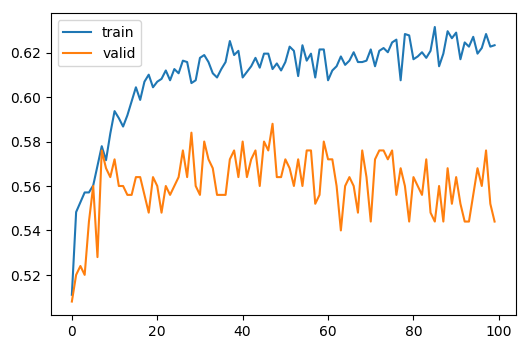

In [143]:
train_and_plot(dict(embed_dim=50,hidden=500,num_classes=8),
               dict(num_epochs=100))

Train Loss 1.03931813398
Val Loss 1.17034
Train Acc 0.6315457458
Val Acc 0.568


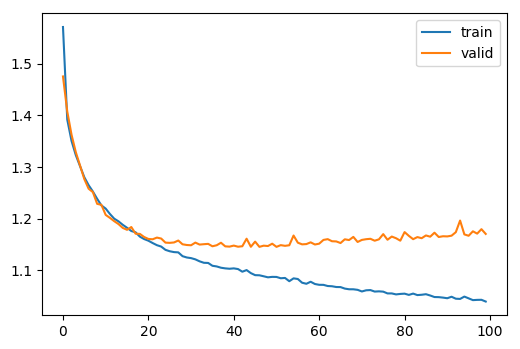

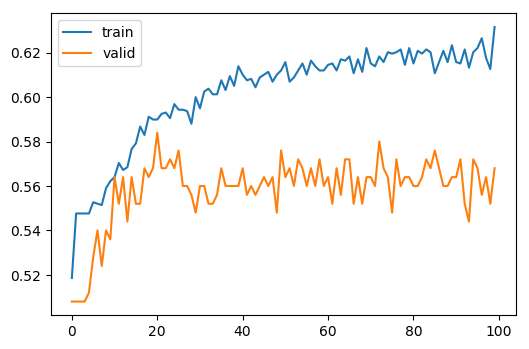

In [144]:
train_and_plot(dict(embed_dim=50,hidden=100,num_classes=8),
               dict(num_epochs=100))

In [672]:
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [690]:
from sklearn.manifold import TSNE
label_words = list(set([t for tag in tags for t in tag.split(', ')]))
tags_vecs = get_embeddings(label_words)


tsne = TSNE(n_components=2, random_state=0)
tags_2d = tsne.fit_transform(tags_vecs)

In [692]:
p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="word2vec T-SNE for most common words")

source = ColumnDataSource(data=dict(x1=tags_2d[:,0],
                                    x2=tags_2d[:,1],
                                    names=label_words))

p.scatter(x="x1", y="x2", size=8, source=source)

labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
p.add_layout(labels)

show(p)